# Toy Model J=0, J=1 with two F levels, J'=1
All with only mF=0

In [1]:
import sys
sys.path.append("..")

import time
import pprint
import numpy as np
from tqdm import tqdm
import multiprocessing
from sympy import Symbol
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
from optical_bloch.utils.general import flatten
from optical_bloch import Hamiltonian, Dissipator, BlochEquations
from multi_helper_funcs import multi_solve_ode, multi_solve_ode_integrate_excited

In [2]:
E0 = Symbol(u'E0', real = True)
E1 = Symbol(u'E1', real = True)
E2 = Symbol(u'E2', real = True)
Ee = Symbol(u'Ee', real = True)

ωl = Symbol(u'ωl', real = True)
Ωl = Symbol(u'Ωl', real = True)
ωμ = Symbol(u'ωμ', real = True)
Ωμ = Symbol(u'Ωμ', real = True)

Δl = Symbol(u'Δl', real = True)
Δμ = Symbol(u'Δμ', real = True)

a = Symbol('a', real = True)
b = Symbol('b', real = True)
α = Symbol('α', real = True)
β = Symbol('β', real = True)

Δ = Symbol('Δ', real = True)

Toy model with a single J=0 state coupled via microwaves to J=1 with 2 sublevels, and J=1 is coupled with a laser to J'=1, assuming only mF=0 levels

In [3]:
ham = Hamiltonian(4)
ham.addEnergies([E0, E1, E2, Ee])
ham.addCoupling(1,3,a*Ωl, ωl)
ham.addCoupling(2,3,b*Ωl, ωl)
ham.addCoupling(0,1,α*Ωμ, ωμ)
ham.addCoupling(0,2,β*Ωμ, ωμ)
ham.eqnTransform()
ham.defineZero(Ee)
ham.defineStateDetuning(1,3,Δl)
ham.defineStateDetuning(2,3,Δl)
ham.defineStateDetuning(0,1,Δμ)
ham.defineStateDetuning(0,2,Δμ)

In [4]:
Γ21 = Symbol(u'Γ21', real = True)
dis = Dissipator(4)
dis.addDecay(3,1,Γ21/2)
dis.addDecay(3,2,Γ21/2)

In [5]:
ham.hamiltonian

Matrix([
[                      E0,  -Ωμ*α*exp(1.0*I*t*ωμ)/2,  -Ωμ*β*exp(1.0*I*t*ωμ)/2,                       0],
[-Ωμ*α*exp(-1.0*I*t*ωμ)/2,                       E1,                        0, -a*Ωl*exp(1.0*I*t*ωl)/2],
[-Ωμ*β*exp(-1.0*I*t*ωμ)/2,                        0,                       E2, -b*Ωl*exp(1.0*I*t*ωl)/2],
[                       0, -a*Ωl*exp(-1.0*I*t*ωl)/2, -b*Ωl*exp(-1.0*I*t*ωl)/2,                      Ee]])

In [6]:
from sympy import nsimplify

In [7]:
ham.transformed = nsimplify(ham.transformed)
ham.transformed = ham.transformed.subs(-E1+E2, Symbol('Δ', real = True))
ham.transformed

Matrix([
[-Δl - Δμ, -Ωμ*α/2, -Ωμ*β/2,       0],
[ -Ωμ*α/2,     -Δl,       0, -a*Ωl/2],
[ -Ωμ*β/2,       0,  Δ - Δl, -b*Ωl/2],
[       0, -a*Ωl/2, -b*Ωl/2,       0]])

In [8]:
bloch = BlochEquations(4, dis.density_matrix, ham.transformed, dis.dissipator)

In [9]:
y0 = np.zeros([bloch.levels, bloch.levels], dtype = complex)
y0[1,1] = 1/2
y0[2,2] = 1/2
y0 = y0.flatten()

In [10]:
Γ21_val = 1
replacements = [(Δl, 0),
                (Δμ, 0),
                (a, 1),
                (b, 1),
                (α, 1/3),
                (β, 2/3),
                (Ωl, 0.2*Γ21_val),
                (Ωμ, 0.2*Γ21_val),
                (Δ, 0*Γ21_val),
                (Γ21, Γ21_val)]

In [11]:
%%time
sol = bloch.solveNumeric(replacements, [0,300], y0, method = 'BDF')

Wall time: 1.15 s


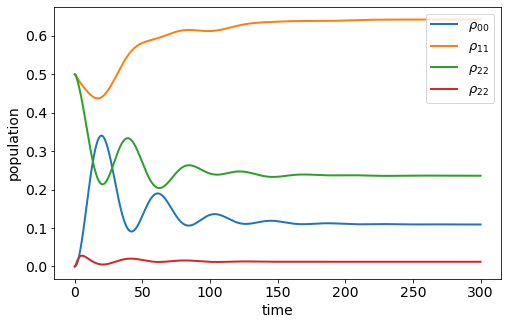

In [12]:
r = np.einsum("iij->ij", sol.y.reshape(4,4,sol.t.size)).real

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(sol.t, r[0], label = r'$\rho_{00}$', lw = 2)
ax.plot(sol.t, r[1], label = r'$\rho_{11}$', lw = 2)
ax.plot(sol.t, r[2], label = r'$\rho_{22}$', lw = 2)
ax.plot(sol.t, r[3], label = r'$\rho_{22}$', lw = 2)

ax.legend(fontsize = 13)
ax.set_xlabel('time')
ax.set_ylabel('population')

set_fontsize(ax, 14)

In [13]:
from julia import Main

In [ ]:
nprocs = 12 # number of processes to use for EnsembleDistributed
Main.eval(f"""
using BenchmarkTools
using Distributed
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using ModelingToolkit
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    using ModelingToolkit
end
""")

    
Main.eval("procs()")

In [15]:
from sympy import MutableDenseMatrix, conjugate, Function, Symbol

t = Symbol('t', real = True)

hamiltonian_symbols = ham.transformed.free_symbols
dissipator_symbols = dis.dissipator.free_symbols
dissipator_symbols = set([d for d in dissipator_symbols if str(d)[0] not in ['ρ', 't']])

for s in list(hamiltonian_symbols) + list(dissipator_symbols):
    Main.eval(f"""
                @everywhere @parameters {str(s)}
                tmp = 0
            """);


lx, ly = ham.transformed.shape
Main.eval(f"""
            @everywhere begin
            H = zeros(Num, {lx}, {ly})
            L = zeros(Num, {lx}, {ly})
            @variables t ρ[1:{lx},1:{ly}](t)
            @parameters icomplex
            D = Differential(t)
            tmp = 0
            end
            """);

diss = MutableDenseMatrix(dis.dissipator.copy())

for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(j+1, i+1))
        diss = diss.subs(conjugate(tmp(t)), tmp1(t))
            
for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(i+1, j+1))
        diss = diss.subs(tmp(t), tmp1(t))


for idx in range(1,lx+1):
    for idy in range(1,ly+1):
        hval = str(ham.transformed[idx-1,idy-1])
        dval = str(diss[idx-1, idy-1])
        dval = dval.replace('(t)', '')
        Main.eval(f"""
                @everywhere begin
                H[{idx},{idy}] = {hval}
                L[{idx},{idy}] = {dval}
                tmp = 0
                end
                """);
        
# ham_pars = ham.transformed.free_symbols

In [16]:
ham_string = ','.join([str(h) for h in hamiltonian_symbols])
diss_string = ','.join([str(d) for d in dissipator_symbols])

Main.eval(f"""
@everywhere begin
    eq = -icomplex*Symbolics.scalarize(H*ρ-ρ*H) + L
    eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:{lx} for idy in 1:{ly}];
    bloch = ODESystem(eqns)

    tmp = 0
end
""");

In [17]:
y0 = np.zeros([ham.levels, ham.levels], dtype = complex)
for _ in range(1,3):
    y0[_,_] = 1/2
Main.ρ_ini = y0
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [21]:
Main.eval("""
    @everywhere begin
    p = [
    Ωl => 1,
    Ωμ => 1,
    a => 1,
    b => 1,
    α => 1/3,
    β => 2/3,
    Δ => 0.12,
    Δμ => 0,
    Δl => 0,
    Γ21 => 1,
    icomplex => im
    ]
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:dim for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

In [23]:
Main.eval("""
@everywhere begin
    tspan = (0.0, 300.)
    prob = ODEProblem(bloch, ρ_ini, tspan, p, jac = true)
end
""");

In [24]:
Main.eval("@time sol = solve(prob, Tsit5(), abstol = 1e-10, reltol = 1e-10)");

In [25]:
ut = np.array(Main.eval("sol[:]"))
dim = int(np.sqrt(ut.shape[1]))
pop_results = np.real(np.einsum('jji->ji',ut.reshape(-1,dim, dim).T))
t_array = Main.eval("sol.t") 

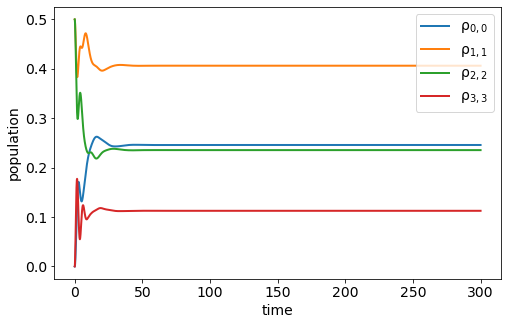

In [26]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

## Ensemble Problem $\Delta = 4$

In [30]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][end]) for j in 1:size(sol.u)[1]]), false
       end
""")

In [31]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        Ωl => params[i,1],
        Ωμ => params[i,2],
        a => 1,
        b => 1,
        α => 1/3,
        β => 2/3,
        Δ => 4,
        Δμ => 0,
        Δl => 0,
        Γ21 => 1,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [32]:
Ωls = np.linspace(0,20,101)
Ωμs = np.linspace(0,20,101)
params = np.array(np.meshgrid(Ωls, Ωμs)).T.reshape(-1,2)
Main.params = params
Main.eval("@everywhere params = $params")

In [33]:
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [34]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

44.9642047

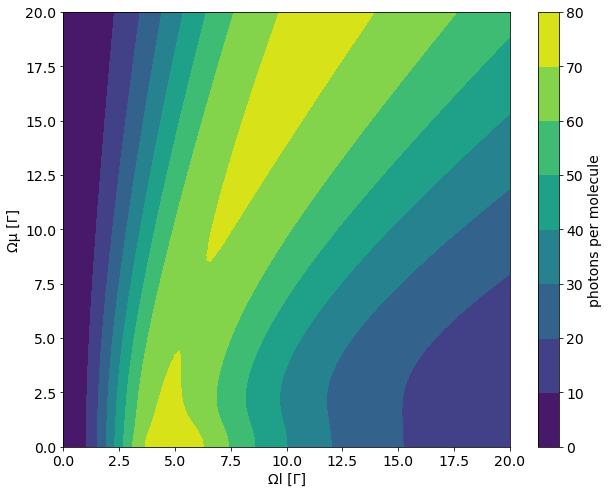

In [35]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0], params[:,1], np.array(Main.eval("sim.u")))

cbar = fig.colorbar(tcf)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel(r'Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## Ensemble Problem $\Delta = 0.12$

In [36]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        Ωl => params[i,1],
        Ωμ => params[i,2],
        a => 1,
        b => 1,
        α => 1/3,
        β => 2/3,
        Δ => 0.12,
        Δμ => 0,
        Δl => 0,
        Γ21 => 1,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [37]:
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [38]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

24.9555365

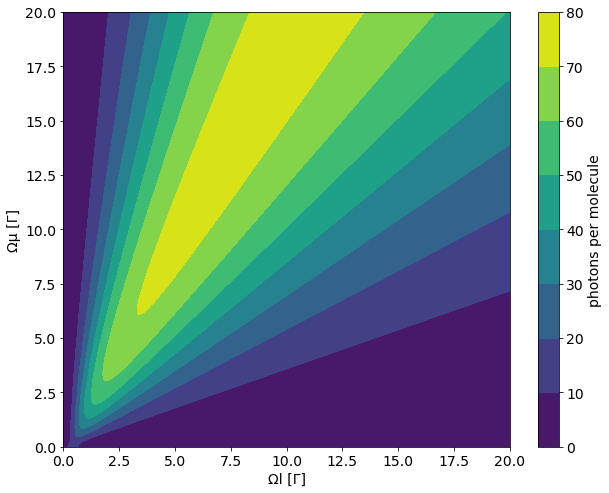

In [39]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0], params[:,1], np.array(Main.eval("sim.u")))

cbar = fig.colorbar(tcf)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel(r'Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## Ensemble Problem Scan microwave detuning and energy splitting

In [41]:
Δμs = np.linspace(-5,5,101)
Δs = np.linspace(0,4,101)
params = np.array(np.meshgrid(Δμs, Δs)).T.reshape(-1,2)
Main.params = params
Main.eval("@everywhere params = $params")

In [45]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        Ωl => 2.5,
        Ωμ => 2.5,
        a => 1,
        b => 1,
        α => 1/3,
        β => 2/3,
        Δ => params[i,2],
        Δμ => params[i,1],
        Δl => 0,
        Γ21 => 1,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [46]:
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [47]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

11.824845

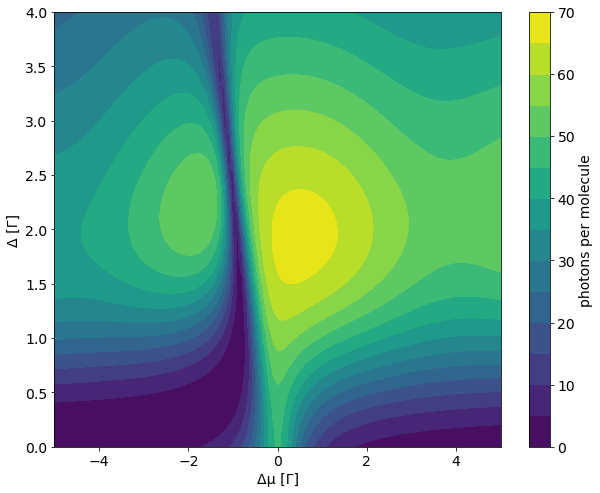

In [48]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0], params[:,1], np.array(Main.eval("sim.u")), levels = 15)

cbar = fig.colorbar(tcf)

ax.set_xlabel('Δμ [Γ]')
ax.set_ylabel(r'Δ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

# Scans with approximate numbers from real system to J'=1, F'=0 F$_1$' = 1/2
a = 0.63  
b = 0.37  
Δ = 0.12Γ  
α = -0.41  
β = 0.59  

In [62]:
Ωls = np.linspace(0,20,101)
Ωμs = np.linspace(0,20,101)
params = np.array(np.meshgrid(Ωls, Ωμs)).T.reshape(-1,2)
Main.params = params
Main.eval("@everywhere params = $params")

In [63]:
Main.eval("parameters(bloch)")

[<PyCall.jlwrap icomplex>,
 <PyCall.jlwrap α>,
 <PyCall.jlwrap β>,
 <PyCall.jlwrap Ωμ>,
 <PyCall.jlwrap a>,
 <PyCall.jlwrap Δμ>,
 <PyCall.jlwrap Ωl>,
 <PyCall.jlwrap Δl>,
 <PyCall.jlwrap b>,
 <PyCall.jlwrap Δ>,
 <PyCall.jlwrap Γ21>]

In [64]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        Ωl => params[i,1],
        Ωμ => params[i,2],
        a => 0.63,
        b => 0.37,
        α => 0.41,
        β => 0.59,
        Δ => 0.12,
        Δμ => 0,
        Δl => 0,
        Γ21 => 1,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [65]:
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [66]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

23.0020091

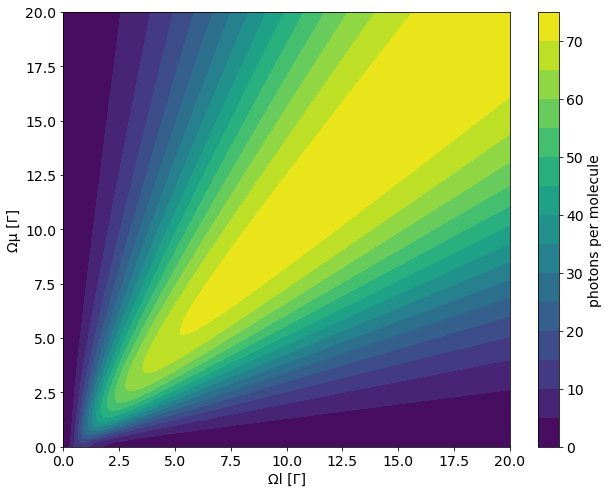

In [67]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0], params[:,1], np.array(Main.eval("sim.u")), levels = 15)

cbar = fig.colorbar(tcf)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel('Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [68]:
Δμs = np.linspace(-5,5,101)
Ωmus = np.linspace(0,10,101)
params = np.array(np.meshgrid(Δμs, Ωmus)).T.reshape(-1,2)
Main.params = params
Main.eval("@everywhere params = $params")

In [69]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
        Ωl => 2.5,
        Ωμ => params[i,2],
        a => 0.63,
        b => 0.37,
        α => 0.41,
        β => 0.59,
        Δ => 0.12,
        Δμ => params[i,1],
        Δl => 0,
        Γ21 => 1,
        icomplex => im
        ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [70]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
           remake(prob, p = [im, 0.41, 0.59, params[i,2], 0.63, params[i,1], 2.5, 0, 0.37, 0.12, 1])
       end
""")

In [71]:
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [72]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                   save_everystep = true; trajectories = size(params)[1], adaptive=true, 
                   abstol = 1e-9, reltol =1e-6)
sim.elapsedTime
""")

16.2921755

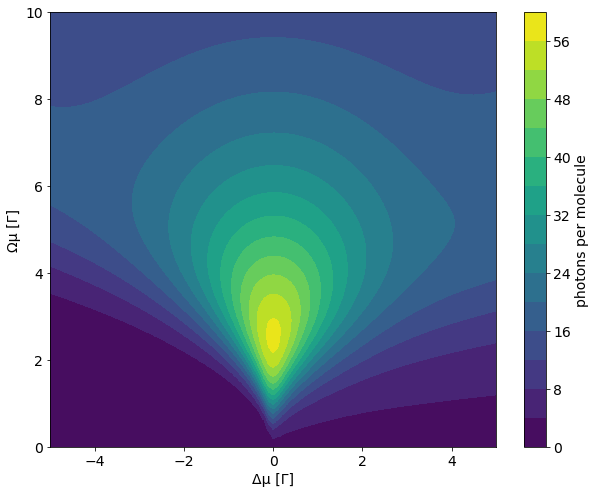

In [73]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0], params[:,1], np.array(Main.eval("sim.u")), levels = 15)

cbar = fig.colorbar(tcf)

ax.set_xlabel('Δμ [Γ]')
ax.set_ylabel('Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)